<center><b>Tensorflow Keras model to train on the GTEx data</b></center>

#### __Aim__: To build a TensorFlow Keras model, train on the available gene expression data to identify the age of the owner of the gene expression.

In [2]:
#Import the required packages

import os
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#### Extract the meta information from the data

In [3]:
def GTEx_sample_shrinker(meta,by_col,n=20):
    by=meta[by_col].unique()
    ans=[]
    for i in by:
        nTissue=len(meta[meta[by_col]==i])
        if nTissue<n:
            nn=nTissue
        else:
            nn=n
        ans.append(meta[meta[by_col]==i].sample(nn))
    selectedMeta=pd.concat(ans)
    return selectedMeta

current_dir = os.getcwd() #current directory
data_dir = os.path.join(current_dir, "data")
manifest={"data":"All_Tissue_Site_Details.combined.reads.gct",
          "sample_meta":"GTEx_v7_Annotations_SampleAttributesDS.txt",
          "subject_meta":"GTEx_v7_Annotations_SubjectPhenotypesDS.txt",
           "merged_meta":"merged_meta.tsv"}
meta=pd.read_csv(os.path.join(data_dir, manifest['merged_meta']),sep="\t",dtype={'SMUBRID':object})
y=GTEx_sample_shrinker(meta,'SMTS',20)
y.to_csv(os.path.join(data_dir,"filteredMeta.tsv"),sep="\t",index=False)
y['SAMPID'].to_csv(os.path.join(data_dir,"filteredSAMPID.tsv"),sep="\t",index=False)

#### Identify all the unique tissue types before building the DL model

In [4]:
fileName = os.path.join(data_dir, "merged_meta.tsv")
meta=pd.read_csv(os.path.join(data_dir,manifest['merged_meta']),sep="\t",dtype={'SMUBRID':object,'SEX':object,'DTHHRDY':object})

meta=meta[~(meta['AGE'].isnull())] # removes all samples without age

#Extract only the tissue types with count > 200
counts=pd.DataFrame(meta['SMTS'].value_counts())
df=meta[meta['SMTS'].isin(counts[counts['SMTS'] > 200].index)]

#Identify the unique tissue types
tissue_types = df['SMTS'].unique()

print("Unique tissue types in the GTEx data: ", [t for t in tissue_types])

Unique tissue types in the GTEx data:  ['Adipose Tissue', 'Blood Vessel', 'Brain', 'Breast', 'Blood', 'Skin', 'Colon', 'Esophagus', 'Heart', 'Lung', 'Muscle', 'Nerve', 'Pancreas', 'Stomach', 'Testis', 'Thyroid']


#### Building the keras model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

class keras_model:
    DATA_DIR = "keras_models"
    
    def __init__(self):
        self.early_stopping_monitor = EarlyStopping(patience=3) #Hyperparameter tuning
        
    def construct_model(self, x_train, y_train):
        self.model = tf.keras.models.Sequential() #Sequential model
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(1024, input_dim=x_train.shape[1], activation=tf.nn.relu))
        self.model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
        self.model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
        #self.model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
        self.model.add(tf.keras.layers.Dense(y_train.shape[1], activation=tf.nn.softmax))
        #Note: Output layer is designed to hold the number of neurons equivalent to the number of classes of age groups

        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    def model_train(self, x_train, y_train):
        if x_train.shape[0] == y_train.shape[0]: #Checking shape since there are tissues with missing gene expressions
            try:
                print("Training Keras model...")
                
                self.construct_model(x_train, y_train) #Constructing the model
                self.model.fit(x_train, 
                               y_train, 
                               batch_size=32, #Setting batch size for ease of processing in local machines
                               epochs=30, #Maximum of 30 epochs
                               validation_split=0.1, 
                               callbacks=[self.early_stopping_monitor]) #Early stopping hyperparameter
                
                print("Evaluating training accuracy...")
                loss, accuracy = self.model.evaluate(x_train, y_train)
                
                try:
                    #Persisting the model trained for the corresponding tissue type
                    fileName = TISSUE + "_keras_model.h5"
                    filePath = os.path.join(self.DATA_DIR, fileName)
                    self.model.save(filePath)
                    return accuracy, fileName
                except:
                    print("Exception while saving the model.")
                    return accuracy, None
            except:
                print("Exception while processing!")
                return -1, None
        else:
            print("Shape mismatch encountered!")
            return -1, None

#### Train the model for each tissue type

#### Persist the results of the model in a TSV file for evaluation later

In [17]:
#Death Hardy effect

tissue_specific_path = "tissue-specific"

tissue_type = []
tissue_model_persist = []
tissue_model_accuracy = []

for tissue in tissue_types:
    k_model = keras_model()
    TISSUE=tissue
    infiles=os.listdir(tissue_specific_path)
    TISSUE_files=[f for f in infiles if  TISSUE in f]
    for entry in TISSUE_files:
        if "_cpm" in entry: #Identify the file with _cpm suffix; cpm stands for Counts Per Million
            pdd = pd.read_csv(os.path.join(tissue_specific_path,entry), sep='\t')
            tissue_meta=meta[meta['SMTS']==TISSUE]
            death_y = tissue_meta['DTHHRDY']
            
            
            print("Tissue type: ", TISSUE)
            if pdd.shape[0] != tissue_meta.shape[0]:
                print("Shape mismatch!\n")
                break

            #Dropping the gene id colunm since it plays no role in classification
            pdd = pdd.drop(pdd.columns[0], axis='columns')

            #Min_max normalization
            min_max_scaler = preprocessing.MinMaxScaler()
            np_scaled = min_max_scaler.fit_transform(pdd)
            pdd = pd.DataFrame(np_scaled)
            
            #Categorizing the target column and performing one-hot encoding
            encoder = LabelEncoder()
            encoder.fit(death_y.astype(str))
            encoded_Y = encoder.transform(death_y.astype(str))
            dummy_y = tf.keras.utils.to_categorical(encoded_Y)
            
            #Training the model for the current tissue type
            numpy_matrix = pdd.as_matrix()
            acc, fileName = k_model.model_train(numpy_matrix, dummy_y)
            if acc != -1:
                try:
                    acc = acc * 100
                    tissue_type.append(TISSUE)
                    tissue_model_persist.append(fileName)
                    tissue_model_accuracy.append(acc)
                    print("Final accuracy:", acc)
                except:
                    print("Error occurred for tissue type: ", TISSUE)
            print("\n")
            break
            

Tissue type:  Adipose Tissue


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 717 samples, validate on 80 samples
Epoch 1/30
717/717 [==============================] - 12s 17ms/sample - loss: 6.9614 - acc: 0.5286 - val_loss: 4.0295 - val_acc: 0.7500
Epoch 2/30
717/717 [==============================] - 11s 16ms/sample - loss: 7.1936 - acc: 0.5537 - val_loss: 4.0295 - val_acc: 0.7500
Epoch 3/30
717/717 [==============================] - 11s 16ms/sample - loss: 7.1936 - acc: 0.5537 - val_loss: 4.0295 - val_acc: 0.7500
Epoch 4/30
717/717 [==============================] - 11s 16ms/sample - loss: 7.1936 - acc: 0.5537 - val_loss: 4.0295 - val_acc: 0.7500
Evaluating training accuracy...
797/797 [==============================] - 3s 3ms/sample - loss: 6.8760 - acc: 0.5734
Final accuracy: 57.340025901794434


Tissue type:  Blood Vessel


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 821 samples, validate on 92 samples
Epoch 1/30
821/821 [==============================] - 15s 18ms/sample - loss: 11.8943 - acc: 0.2217 - val_loss: 14.3661 - val_acc: 0.1087
Epoch 2/30
821/821 [==============================] - 13s 16ms/sample - loss: 12.5254 - acc: 0.2229 - val_loss: 14.3661 - val_acc: 0.1087
Epoch 3/30
821/821 [==============================] - 13s 15ms/sample - loss: 12.5254 - acc: 0.2229 - val_loss: 14.3661 - val_acc: 0.1087
Epoch 4/30
821/821 [==============================] - 13s 16ms/sample - loss: 12.5254 - acc: 0.2229 - val_loss: 14.3661 - val_acc: 0.1087
Epoch 5/30
821/821 [==============================] - 13s 15ms/sample - loss: 12.5254 - acc: 0.2229 - val_loss: 14.3661 - val_acc: 0.1087
Epoch 6/30
821/821 [==============================] - 13s 15ms/sample - loss: 12.5254 - acc: 0.2229 - val_loss: 14.3661 - val_acc: 0.1087
Epoch 7/30
821/821 [==============================] - 13s 16ms/sample - loss: 12.5254 - acc: 0.2229 - v

C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 297 samples, validate on 34 samples
Epoch 1/30
297/297 [==============================] - 6s 20ms/sample - loss: 5.7565 - acc: 0.6061 - val_loss: 9.4812 - val_acc: 0.4118
Epoch 2/30
297/297 [==============================] - 5s 16ms/sample - loss: 6.1867 - acc: 0.6162 - val_loss: 9.4812 - val_acc: 0.4118
Epoch 3/30
297/297 [==============================] - 5s 16ms/sample - loss: 6.1867 - acc: 0.6162 - val_loss: 9.4812 - val_acc: 0.4118
Epoch 4/30
297/297 [==============================] - 5s 16ms/sample - loss: 6.1867 - acc: 0.6162 - val_loss: 9.4812 - val_acc: 0.4118
Epoch 5/30
297/297 [==============================] - 5s 16ms/sample - loss: 6.1867 - acc: 0.6162 - val_loss: 9.4812 - val_acc: 0.4118
Evaluating training accuracy...
331/331 [==============================] - 1s 3ms/sample - loss: 6.5252 - acc: 0.5952
Final accuracy: 59.51661467552185


Tissue type:  Breast


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 261 samples, validate on 29 samples
Epoch 1/30
261/261 [==============================] - 6s 25ms/sample - loss: 6.4735 - acc: 0.4483 - val_loss: 5.5580 - val_acc: 0.6552
Epoch 2/30
261/261 [==============================] - 4s 17ms/sample - loss: 6.9166 - acc: 0.5709 - val_loss: 5.5580 - val_acc: 0.6552
Epoch 3/30
261/261 [==============================] - 5s 20ms/sample - loss: 6.9166 - acc: 0.5709 - val_loss: 5.5580 - val_acc: 0.6552
Epoch 4/30
261/261 [==============================] - 4s 17ms/sample - loss: 6.9166 - acc: 0.5709 - val_loss: 5.5580 - val_acc: 0.6552
Epoch 5/30
261/261 [==============================] - 4s 17ms/sample - loss: 6.9166 - acc: 0.5709 - val_loss: 5.5580 - val_acc: 0.6552
Epoch 6/30
261/261 [==============================] - 4s 17ms/sample - loss: 6.9166 - acc: 0.5709 - val_loss: 5.5580 - val_acc: 0.6552
Evaluating training accuracy...
290/290 [==============================] - 1s 3ms/sample - loss: 6.7807 - acc: 0.5793
Fin

C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 1081 samples, validate on 121 samples
Epoch 1/30
1081/1081 [==============================] - 19s 17ms/sample - loss: 13.7812 - acc: 0.1212 - val_loss: 14.7860 - val_acc: 0.0826
Epoch 2/30
1081/1081 [==============================] - 16s 15ms/sample - loss: 14.3587 - acc: 0.1092 - val_loss: 14.7860 - val_acc: 0.0826
Epoch 3/30
1081/1081 [==============================] - 16s 15ms/sample - loss: 14.3587 - acc: 0.1092 - val_loss: 14.7860 - val_acc: 0.0826
Epoch 4/30
1081/1081 [==============================] - 17s 15ms/sample - loss: 14.3587 - acc: 0.1092 - val_loss: 14.7860 - val_acc: 0.0826
Epoch 5/30
1081/1081 [==============================] - 16s 15ms/sample - loss: 14.3587 - acc: 0.1092 - val_loss: 14.7860 - val_acc: 0.0826
Epoch 6/30
1081/1081 [==============================] - 16s 15ms/sample - loss: 14.3587 - acc: 0.1092 - val_loss: 14.7860 - val_acc: 0.0826
Evaluating training accuracy...
1202/1202 [==============================] - 4s 3ms/sampl

C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 456 samples, validate on 51 samples
Epoch 1/30
456/456 [==============================] - 9s 19ms/sample - loss: 4.8968 - acc: 0.6338 - val_loss: 0.9481 - val_acc: 0.9412
Epoch 2/30
456/456 [==============================] - 7s 16ms/sample - loss: 5.0192 - acc: 0.6886 - val_loss: 0.9481 - val_acc: 0.9412
Epoch 3/30
456/456 [==============================] - 7s 16ms/sample - loss: 5.0192 - acc: 0.6886 - val_loss: 0.9481 - val_acc: 0.9412
Epoch 4/30
456/456 [==============================] - 7s 16ms/sample - loss: 5.0192 - acc: 0.6886 - val_loss: 0.9481 - val_acc: 0.9412
Evaluating training accuracy...
507/507 [==============================] - 2s 4ms/sample - loss: 4.6097 - acc: 0.7140
Final accuracy: 71.40039205551147


Tissue type:  Esophagus


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 918 samples, validate on 103 samples
Epoch 1/30
918/918 [==============================] - 15s 17ms/sample - loss: 4.7414 - acc: 0.6754 - val_loss: 2.1908 - val_acc: 0.8641
Epoch 2/30
918/918 [==============================] - 15s 16ms/sample - loss: 4.8108 - acc: 0.7015 - val_loss: 2.1908 - val_acc: 0.8641
Epoch 3/30
918/918 [==============================] - 14s 15ms/sample - loss: 4.8108 - acc: 0.7015 - val_loss: 2.1908 - val_acc: 0.8641
Epoch 4/30
918/918 [==============================] - 14s 16ms/sample - loss: 4.8108 - acc: 0.7015 - val_loss: 2.1908 - val_acc: 0.8641
Epoch 5/30
918/918 [==============================] - 14s 15ms/sample - loss: 4.8108 - acc: 0.7015 - val_loss: 2.1908 - val_acc: 0.8641
Epoch 6/30
918/918 [==============================] - 14s 15ms/sample - loss: 4.8108 - acc: 0.7015 - val_loss: 2.1908 - val_acc: 0.8641
Evaluating training accuracy...
1021/1021 [==============================] - 4s 3ms/sample - loss: 4.5465 - acc: 0

C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 540 samples, validate on 60 samples
Epoch 1/30
540/540 [==============================] - 10s 18ms/sample - loss: 10.5764 - acc: 0.3000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/30
540/540 [==============================] - 8s 16ms/sample - loss: 11.7901 - acc: 0.2685 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/30
540/540 [==============================] - 8s 15ms/sample - loss: 11.7901 - acc: 0.2685 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/30
540/540 [==============================] - 8s 15ms/sample - loss: 11.7901 - acc: 0.2685 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/30
540/540 [==============================] - 8s 15ms/sample - loss: 11.7901 - acc: 0.2685 - val_loss: 14.5063 - val_acc: 0.1000
Evaluating training accuracy...
600/600 [==============================] - 2s 4ms/sample - loss: 12.0617 - acc: 0.2517
Final accuracy: 25.166666507720947


Tissue type:  Lung


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 384 samples, validate on 43 samples
Epoch 1/30
384/384 [==============================] - 8s 21ms/sample - loss: 10.7050 - acc: 0.2396 - val_loss: 14.2439 - val_acc: 0.1163
Epoch 2/30
384/384 [==============================] - 6s 16ms/sample - loss: 12.0046 - acc: 0.2552 - val_loss: 14.2439 - val_acc: 0.1163
Epoch 3/30
384/384 [==============================] - 6s 15ms/sample - loss: 12.0046 - acc: 0.2552 - val_loss: 14.2439 - val_acc: 0.1163
Epoch 4/30
384/384 [==============================] - 6s 15ms/sample - loss: 12.0046 - acc: 0.2552 - val_loss: 14.2439 - val_acc: 0.1163
Evaluating training accuracy...
427/427 [==============================] - 1s 3ms/sample - loss: 12.2301 - acc: 0.2412
Final accuracy: 24.121779203414917


Tissue type:  Muscle


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 507 samples, validate on 57 samples
Epoch 1/30
507/507 [==============================] - 11s 21ms/sample - loss: 7.1047 - acc: 0.5247 - val_loss: 7.6349 - val_acc: 0.5263
Epoch 2/30
507/507 [==============================] - 9s 17ms/sample - loss: 7.5345 - acc: 0.5325 - val_loss: 7.6349 - val_acc: 0.5263
Epoch 3/30
507/507 [==============================] - 9s 18ms/sample - loss: 7.5345 - acc: 0.5325 - val_loss: 7.6349 - val_acc: 0.5263
Epoch 4/30
507/507 [==============================] - 8s 16ms/sample - loss: 7.5345 - acc: 0.5325 - val_loss: 7.6349 - val_acc: 0.5263
Evaluating training accuracy...
564/564 [==============================] - 2s 4ms/sample - loss: 7.5446 - acc: 0.5319
Final accuracy: 53.19148898124695


Tissue type:  Nerve


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 372 samples, validate on 42 samples
Epoch 1/30
372/372 [==============================] - 8s 23ms/sample - loss: 6.9134 - acc: 0.5000 - val_loss: 6.5240 - val_acc: 0.5952
Epoch 2/30
372/372 [==============================] - 6s 16ms/sample - loss: 7.4958 - acc: 0.5349 - val_loss: 6.5240 - val_acc: 0.5952
Epoch 3/30
372/372 [==============================] - 6s 16ms/sample - loss: 7.4958 - acc: 0.5349 - val_loss: 6.5240 - val_acc: 0.5952
Epoch 4/30
372/372 [==============================] - 6s 17ms/sample - loss: 7.4958 - acc: 0.5349 - val_loss: 6.5240 - val_acc: 0.5952
Epoch 5/30
372/372 [==============================] - 6s 16ms/sample - loss: 7.4958 - acc: 0.5349 - val_loss: 6.5240 - val_acc: 0.5952
Epoch 6/30
372/372 [==============================] - 6s 17ms/sample - loss: 7.4958 - acc: 0.5349 - val_loss: 6.5240 - val_acc: 0.5952
Epoch 7/30
372/372 [==============================] - 6s 16ms/sample - loss: 7.4958 - acc: 0.5349 - val_loss: 6.5240 - va

C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 223 samples, validate on 25 samples
Epoch 1/30
223/223 [==============================] - 5s 23ms/sample - loss: 2.1909 - acc: 0.7444 - val_loss: 2.5789 - val_acc: 0.8400
Epoch 2/30
223/223 [==============================] - 4s 18ms/sample - loss: 2.1684 - acc: 0.8655 - val_loss: 2.5789 - val_acc: 0.8400
Epoch 3/30
223/223 [==============================] - 4s 16ms/sample - loss: 2.1684 - acc: 0.8655 - val_loss: 2.5789 - val_acc: 0.8400
Epoch 4/30
223/223 [==============================] - 4s 18ms/sample - loss: 2.1684 - acc: 0.8655 - val_loss: 2.5789 - val_acc: 0.8400
Evaluating training accuracy...
248/248 [==============================] - 2s 7ms/sample - loss: 2.2097 - acc: 0.8629 0s - loss: 2.5185 - acc: 0.84
Final accuracy: 86.29032373428345


Tissue type:  Stomach


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 234 samples, validate on 27 samples
Epoch 1/30
234/234 [==============================] - 6s 24ms/sample - loss: 2.1690 - acc: 0.7607 - val_loss: 2.3879 - val_acc: 0.8519
Epoch 2/30
234/234 [==============================] - 4s 17ms/sample - loss: 2.2042 - acc: 0.8632 - val_loss: 2.3879 - val_acc: 0.8519
Epoch 3/30
234/234 [==============================] - 4s 17ms/sample - loss: 2.2042 - acc: 0.8632 - val_loss: 2.3879 - val_acc: 0.8519
Epoch 4/30
234/234 [==============================] - 4s 17ms/sample - loss: 2.2042 - acc: 0.8632 - val_loss: 2.3879 - val_acc: 0.8519
Evaluating training accuracy...
261/261 [==============================] - 1s 4ms/sample - loss: 2.2232 - acc: 0.8621
Final accuracy: 86.20689511299133


Tissue type:  Testis


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 233 samples, validate on 26 samples
Epoch 1/30
233/233 [==============================] - 7s 30ms/sample - loss: 6.3707 - acc: 0.5236 - val_loss: 4.3395 - val_acc: 0.7308
Epoch 2/30
233/233 [==============================] - 5s 21ms/sample - loss: 7.1943 - acc: 0.5536 - val_loss: 4.3395 - val_acc: 0.7308
Epoch 3/30
233/233 [==============================] - 5s 19ms/sample - loss: 7.1943 - acc: 0.5536 - val_loss: 4.3395 - val_acc: 0.7308
Epoch 4/30
233/233 [==============================] - 5s 20ms/sample - loss: 7.1943 - acc: 0.5536 - val_loss: 4.3395 - val_acc: 0.7308
Evaluating training accuracy...
259/259 [==============================] - 1s 5ms/sample - loss: 6.9078 - acc: 0.5714
Final accuracy: 57.14285969734192


Tissue type:  Thyroid


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 401 samples, validate on 45 samples
Epoch 1/30
401/401 [==============================] - 9s 23ms/sample - loss: 6.6127 - acc: 0.5536 - val_loss: 5.7309 - val_acc: 0.6444
Epoch 2/30
401/401 [==============================] - 7s 16ms/sample - loss: 7.1145 - acc: 0.5586 - val_loss: 5.7309 - val_acc: 0.6444
Epoch 3/30
401/401 [==============================] - 6s 16ms/sample - loss: 7.1145 - acc: 0.5586 - val_loss: 5.7309 - val_acc: 0.6444
Epoch 4/30
401/401 [==============================] - 6s 16ms/sample - loss: 7.1145 - acc: 0.5586 - val_loss: 5.7309 - val_acc: 0.6444
Evaluating training accuracy...
446/446 [==============================] - 2s 3ms/sample - loss: 6.9749 - acc: 0.5673
Final accuracy: 56.72645568847656




In [25]:
keras_model_pd = pd.DataFrame(
    data = {
        'tissue_type': tissue_type,
        'model_file': tissue_model_persist,
        'model_accuracy': tissue_model_accuracy
    }
)

keras_model_pd = keras_model_pd.sort_values('tissue_type')

keras_model_pd.to_csv("keras_model_Hardy_results_unfiltered.tsv",sep="\t",index=False)

keras_filtered_pd = keras_model_pd.copy()

keras_filtered_pd

,tissue_type,model_file,model_accuracy
0,Adipose Tissue,Adipose Tissue_keras_model.h5,57.340026
1,Blood Vessel,Blood Vessel_keras_model.h5,21.139102
2,Brain,Brain_keras_model.h5,59.516615
3,Breast,Breast_keras_model.h5,57.931036
5,Colon,Colon_keras_model.h5,71.400392
6,Esophagus,Esophagus_keras_model.h5,71.792358
7,Heart,Heart_keras_model.h5,25.166667
8,Lung,Lung_keras_model.h5,24.121779
9,Muscle,Muscle_keras_model.h5,53.191489
10,Nerve,Nerve_keras_model.h5,54.106277


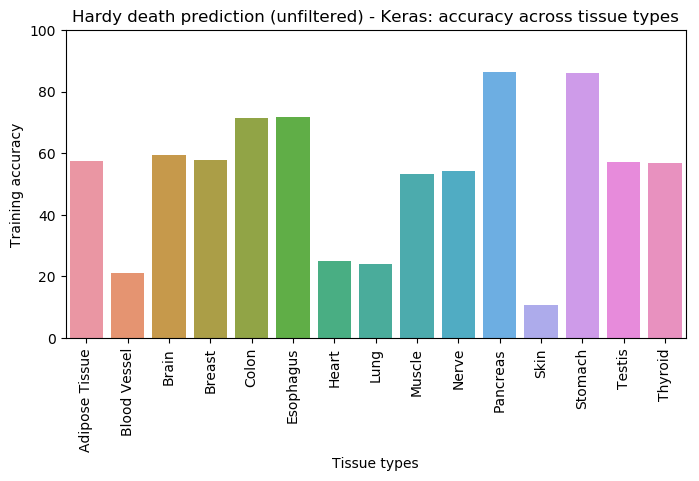

In [29]:
mpl.style.use('default')
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

model_plot = sns.barplot(x = keras_filtered_pd['tissue_type'],
            y=keras_filtered_pd['model_accuracy'],
            data = keras_filtered_pd,
            orient='v',
            estimator=np.mean,
            capsize=0.1)

tick_labels = keras_filtered_pd['tissue_type'].as_matrix()
ax.set_xticklabels(tick_labels,rotation=90)
ax.set(ylim=(0,100))
ax.set(title='Hardy death prediction (unfiltered) - Keras: accuracy across tissue types')
ax.set(xlabel='Tissue types')
ax.set(ylabel='Training accuracy')

plt.show()
test = model_plot.get_figure()
test.savefig('keras_hardy_unfiltered_results.png', bbox_inches='tight')

In [7]:
#Death Hardy effect

tissue_specific_path = "tissue-specific"

tissue_type = []
tissue_model_persist = []
tissue_model_accuracy = []

for tissue in tissue_types:
    k_model = keras_model()
    TISSUE=tissue
    infiles=os.listdir(tissue_specific_path)
    TISSUE_files=[f for f in infiles if  TISSUE in f]
    for entry in TISSUE_files:
        if "_cpm" in entry: #Identify the file with _cpm suffix; cpm stands for Counts Per Million
            pdd = pd.read_csv(os.path.join(tissue_specific_path,entry), sep='\t')
            tissue_meta=meta[meta['SMTS']==TISSUE]
            death_y = tissue_meta['DTHHRDY']
            
            
            print("Tissue type: ", TISSUE)
            if pdd.shape[0] != tissue_meta.shape[0]:
                print("Shape mismatch!\n")
                break

            #Dropping the gene id colunm since it plays no role in classification
            pdd = pdd.drop(pdd.columns[0], axis='columns')

            #Min_max normalization
            min_max_scaler = preprocessing.MinMaxScaler()
            np_scaled = min_max_scaler.fit_transform(pdd)
            pdd = pd.DataFrame(np_scaled)
            
            #Drop columns based on filter
            pdd = pd.concat([pdd, death_y], axis=1)
            pdd = pdd[pdd['DTHHRDY'].isin(['0.0', '1.0', '2.0'])]
            death_y = pdd['DTHHRDY'].copy()
            pdd = pdd.drop(columns=['DTHHRDY'])
            
            #Categorizing the target column and performing one-hot encoding
            encoder = LabelEncoder()
            encoder.fit(death_y.astype(str))
            encoded_Y = encoder.transform(death_y.astype(str))
            dummy_y = tf.keras.utils.to_categorical(encoded_Y)
            
            #Training the model for the current tissue type
            numpy_matrix = pdd.as_matrix()
            acc, fileName = k_model.model_train(numpy_matrix, dummy_y)
            if acc != -1:
                try:
                    acc = acc * 100
                    tissue_type.append(TISSUE)
                    tissue_model_persist.append(fileName)
                    tissue_model_accuracy.append(acc)
                    print("Final accuracy:", acc)
                except:
                    print("Error occurred for tissue type: ", TISSUE)
            print("\n")
            break

Tissue type:  Adipose Tissue


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 613 samples, validate on 69 samples
Epoch 1/30
613/613 [==============================] - 9s 15ms/sample - loss: 5.3133 - acc: 0.6509 - val_loss: 2.8031 - val_acc: 0.8261
Epoch 2/30
613/613 [==============================] - 9s 14ms/sample - loss: 5.6006 - acc: 0.6525 - val_loss: 2.8031 - val_acc: 0.8261
Epoch 3/30
613/613 [==============================] - 9s 14ms/sample - loss: 5.6006 - acc: 0.6525 - val_loss: 2.8031 - val_acc: 0.8261
Epoch 4/30
613/613 [==============================] - 9s 14ms/sample - loss: 5.6006 - acc: 0.6525 - val_loss: 2.8031 - val_acc: 0.8261
Evaluating training accuracy...
682/682 [==============================] - 1s 2ms/sample - loss: 5.3176 - acc: 0.6701
Final accuracy: 67.0087993144989


Tissue type:  Blood Vessel


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 709 samples, validate on 79 samples
Epoch 1/30
709/709 [==============================] - 11s 15ms/sample - loss: nan - acc: 0.6869 - val_loss: nan - val_acc: 0.7848
Epoch 2/30
709/709 [==============================] - 10s 14ms/sample - loss: nan - acc: 0.6869 - val_loss: nan - val_acc: 0.7848
Epoch 3/30
709/709 [==============================] - 10s 14ms/sample - loss: nan - acc: 0.6869 - val_loss: nan - val_acc: 0.7848
Evaluating training accuracy...
788/788 [==============================] - 1s 2ms/sample - loss: nan - acc: 0.6967
Final accuracy: 69.67005133628845


Tissue type:  Brain


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 212 samples, validate on 24 samples
Epoch 1/30
212/212 [==============================] - 3s 16ms/sample - loss: nan - acc: 0.0472 - val_loss: nan - val_acc: 0.0833
Epoch 2/30
212/212 [==============================] - 3s 15ms/sample - loss: nan - acc: 0.0472 - val_loss: nan - val_acc: 0.0833
Epoch 3/30
212/212 [==============================] - 3s 15ms/sample - loss: nan - acc: 0.0472 - val_loss: nan - val_acc: 0.0833
Evaluating training accuracy...
236/236 [==============================] - 0s 2ms/sample - loss: nan - acc: 0.0508
Final accuracy: 5.0847455859184265


Tissue type:  Breast


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 223 samples, validate on 25 samples
Epoch 1/30
223/223 [==============================] - 4s 16ms/sample - loss: nan - acc: 0.6682 - val_loss: nan - val_acc: 0.7600
Epoch 2/30
223/223 [==============================] - 3s 14ms/sample - loss: nan - acc: 0.6682 - val_loss: nan - val_acc: 0.7600
Epoch 3/30
223/223 [==============================] - 3s 14ms/sample - loss: nan - acc: 0.6682 - val_loss: nan - val_acc: 0.7600
Evaluating training accuracy...
248/248 [==============================] - 0s 2ms/sample - loss: nan - acc: 0.6774
Final accuracy: 67.7419364452362


Tissue type:  Blood
Shape mismatch!

Tissue type:  Skin


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 889 samples, validate on 99 samples
Epoch 1/30
889/889 [==============================] - 13s 14ms/sample - loss: nan - acc: 0.6265 - val_loss: nan - val_acc: 0.7778
Epoch 2/30
889/889 [==============================] - 12s 14ms/sample - loss: nan - acc: 0.6265 - val_loss: nan - val_acc: 0.7778
Epoch 3/30
889/889 [==============================] - 12s 14ms/sample - loss: nan - acc: 0.6265 - val_loss: nan - val_acc: 0.7778
Evaluating training accuracy...
988/988 [==============================] - 2s 2ms/sample - loss: nan - acc: 0.6417
Final accuracy: 64.17003870010376


Tissue type:  Colon


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 410 samples, validate on 46 samples
Epoch 1/30
410/410 [==============================] - 6s 15ms/sample - loss: nan - acc: 0.7756 - val_loss: nan - val_acc: 0.9565
Epoch 2/30
410/410 [==============================] - 6s 14ms/sample - loss: nan - acc: 0.7756 - val_loss: nan - val_acc: 0.9565
Epoch 3/30
410/410 [==============================] - 6s 14ms/sample - loss: nan - acc: 0.7756 - val_loss: nan - val_acc: 0.9565
Evaluating training accuracy...
456/456 [==============================] - 1s 2ms/sample - loss: nan - acc: 0.7939
Final accuracy: 79.38596606254578


Tissue type:  Esophagus


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 831 samples, validate on 93 samples
Epoch 1/30
831/831 [==============================] - 12s 15ms/sample - loss: nan - acc: 0.7774 - val_loss: nan - val_acc: 0.9355
Epoch 2/30
831/831 [==============================] - 12s 14ms/sample - loss: nan - acc: 0.7774 - val_loss: nan - val_acc: 0.9355
Epoch 3/30
831/831 [==============================] - 12s 14ms/sample - loss: nan - acc: 0.7774 - val_loss: nan - val_acc: 0.9355
Evaluating training accuracy...
924/924 [==============================] - 2s 2ms/sample - loss: nan - acc: 0.7933
Final accuracy: 79.32900190353394


Tissue type:  Heart


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 459 samples, validate on 52 samples
Epoch 1/30
459/459 [==============================] - 7s 15ms/sample - loss: nan - acc: 0.6275 - val_loss: nan - val_acc: 0.8077
Epoch 2/30
459/459 [==============================] - 7s 14ms/sample - loss: nan - acc: 0.6275 - val_loss: nan - val_acc: 0.8077
Epoch 3/30
459/459 [==============================] - 7s 14ms/sample - loss: nan - acc: 0.6275 - val_loss: nan - val_acc: 0.8077
Evaluating training accuracy...
511/511 [==============================] - 1s 2ms/sample - loss: nan - acc: 0.6458
Final accuracy: 64.5792543888092


Tissue type:  Lung


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 328 samples, validate on 37 samples
Epoch 1/30
328/328 [==============================] - 5s 16ms/sample - loss: nan - acc: 0.6494 - val_loss: nan - val_acc: 0.7568
Epoch 2/30
328/328 [==============================] - 5s 15ms/sample - loss: nan - acc: 0.6494 - val_loss: nan - val_acc: 0.7568
Epoch 3/30
328/328 [==============================] - 5s 15ms/sample - loss: nan - acc: 0.6494 - val_loss: nan - val_acc: 0.7568
Evaluating training accuracy...
365/365 [==============================] - 1s 2ms/sample - loss: nan - acc: 0.6603
Final accuracy: 66.02739691734314


Tissue type:  Muscle


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 417 samples, validate on 47 samples
Epoch 1/30
417/417 [==============================] - 7s 18ms/sample - loss: nan - acc: 0.6403 - val_loss: nan - val_acc: 0.7021
Epoch 2/30
417/417 [==============================] - 6s 15ms/sample - loss: nan - acc: 0.6403 - val_loss: nan - val_acc: 0.7021
Epoch 3/30
417/417 [==============================] - 6s 15ms/sample - loss: nan - acc: 0.6403 - val_loss: nan - val_acc: 0.7021
Evaluating training accuracy...
464/464 [==============================] - 1s 2ms/sample - loss: nan - acc: 0.6466
Final accuracy: 64.65517282485962


Tissue type:  Nerve


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 310 samples, validate on 35 samples
Epoch 1/30
310/310 [==============================] - 5s 17ms/sample - loss: nan - acc: 0.6419 - val_loss: nan - val_acc: 0.7143
Epoch 2/30
310/310 [==============================] - 4s 14ms/sample - loss: nan - acc: 0.6419 - val_loss: nan - val_acc: 0.7143
Epoch 3/30
310/310 [==============================] - 5s 17ms/sample - loss: nan - acc: 0.6419 - val_loss: nan - val_acc: 0.7143
Evaluating training accuracy...
345/345 [==============================] - 1s 2ms/sample - loss: nan - acc: 0.6493
Final accuracy: 64.92753624916077


Tissue type:  Pancreas


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 212 samples, validate on 24 samples
Epoch 1/30
212/212 [==============================] - 5s 23ms/sample - loss: nan - acc: 0.9009 - val_loss: nan - val_acc: 0.9583
Epoch 2/30
212/212 [==============================] - 3s 15ms/sample - loss: nan - acc: 0.9009 - val_loss: nan - val_acc: 0.9583
Epoch 3/30
212/212 [==============================] - 3s 15ms/sample - loss: nan - acc: 0.9009 - val_loss: nan - val_acc: 0.9583
Evaluating training accuracy...
236/236 [==============================] - 0s 2ms/sample - loss: nan - acc: 0.9068
Final accuracy: 90.67796468734741


Tissue type:  Stomach


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 225 samples, validate on 25 samples
Epoch 1/30
225/225 [==============================] - 4s 19ms/sample - loss: nan - acc: 0.8978 - val_loss: nan - val_acc: 0.9200
Epoch 2/30
225/225 [==============================] - 4s 16ms/sample - loss: nan - acc: 0.8978 - val_loss: nan - val_acc: 0.9200
Epoch 3/30
225/225 [==============================] - 3s 16ms/sample - loss: nan - acc: 0.8978 - val_loss: nan - val_acc: 0.9200
Evaluating training accuracy...
250/250 [==============================] - 0s 2ms/sample - loss: nan - acc: 0.9000
Final accuracy: 89.99999761581421


Tissue type:  Testis


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 214 samples, validate on 24 samples
Epoch 1/30
214/214 [==============================] - 4s 18ms/sample - loss: nan - acc: 0.6075 - val_loss: nan - val_acc: 0.7500
Epoch 2/30
214/214 [==============================] - 4s 16ms/sample - loss: nan - acc: 0.6075 - val_loss: nan - val_acc: 0.7500
Epoch 3/30
214/214 [==============================] - 3s 14ms/sample - loss: nan - acc: 0.6075 - val_loss: nan - val_acc: 0.7500
Evaluating training accuracy...
238/238 [==============================] - 0s 2ms/sample - loss: nan - acc: 0.6218
Final accuracy: 62.18487620353699


Tissue type:  Thyroid


C:\Users\suji1\Anaconda3\envs\cs418env\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Training Keras model...
Train on 349 samples, validate on 39 samples
Epoch 1/30
349/349 [==============================] - 6s 17ms/sample - loss: nan - acc: 0.6418 - val_loss: nan - val_acc: 0.7436
Epoch 2/30
349/349 [==============================] - 5s 14ms/sample - loss: nan - acc: 0.6418 - val_loss: nan - val_acc: 0.7436
Epoch 3/30
349/349 [==============================] - 5s 14ms/sample - loss: nan - acc: 0.6418 - val_loss: nan - val_acc: 0.7436
Evaluating training accuracy...
388/388 [==============================] - 1s 2ms/sample - loss: nan - acc: 0.6521
Final accuracy: 65.20618796348572




In [8]:
keras_model_pd = pd.DataFrame(
    data = {
        'tissue_type': tissue_type,
        'model_file': tissue_model_persist,
        'model_accuracy': tissue_model_accuracy
    }
)

keras_model_pd = keras_model_pd.sort_values('tissue_type')

keras_model_pd.to_csv("keras_model_Hardy_results_filtered.tsv",sep="\t",index=False)

keras_model_pd

,tissue_type,model_file,model_accuracy
0,Adipose Tissue,Adipose Tissue_keras_model.h5,67.008799
1,Blood Vessel,Blood Vessel_keras_model.h5,69.670051
2,Brain,Brain_keras_model.h5,5.084746
3,Breast,Breast_keras_model.h5,67.741936
5,Colon,Colon_keras_model.h5,79.385966
6,Esophagus,Esophagus_keras_model.h5,79.329002
7,Heart,Heart_keras_model.h5,64.579254
8,Lung,Lung_keras_model.h5,66.027397
9,Muscle,Muscle_keras_model.h5,64.655173
10,Nerve,Nerve_keras_model.h5,64.927536


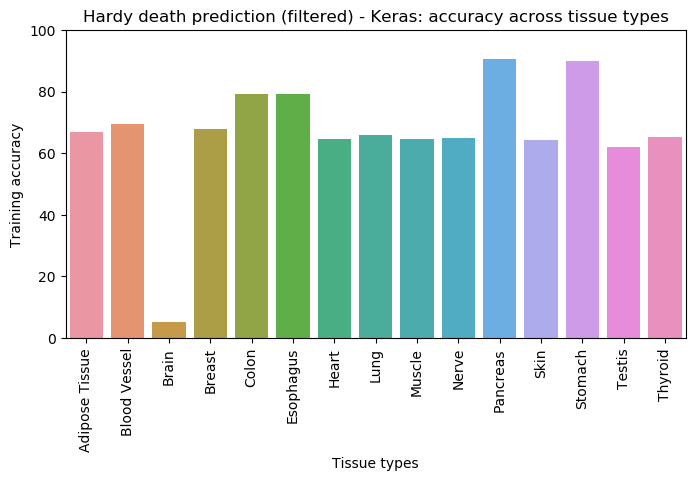

In [9]:
mpl.style.use('default')
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

model_plot = sns.barplot(x = keras_model_pd['tissue_type'],
            y=keras_model_pd['model_accuracy'],
            data = keras_model_pd,
            orient='v',
            estimator=np.mean,
            capsize=0.1)

tick_labels = keras_model_pd['tissue_type'].as_matrix()
ax.set_xticklabels(tick_labels,rotation=90)
ax.set(ylim=(0,100))
ax.set(title='Hardy death prediction (filtered) - Keras: accuracy across tissue types')
ax.set(xlabel='Tissue types')
ax.set(ylabel='Training accuracy')

plt.show()
test = model_plot.get_figure()
test.savefig('keras_hardy_filtered_results.png', bbox_inches='tight')